In [10]:
import scipy.io
import os
import numpy


datapath = "/home/grimur/iokr/data"

In [ ]:
import iokrdata as data

iokrdata = data.IOKRDataServer(datapath, kernel='PPKr.txt')
#iokrdata = IOKRDataServer(datapath)

Loading kernel PPKr.txt


In [3]:
import imp
import iokr
imp.reload(iokr)
import scipy.stats


In [4]:


def cs(a, b):
    """
    cosine similarity
    """
    return numpy.dot(a, b) / (numpy.sqrt(numpy.dot(a, a) * numpy.dot(b, b)))

def test_IOKR_prediction(iokrdata):
    """
    Predict the fingerprint, return the distance from the true fingerprint and a random fingerprint from the CV fold
    """
    res = []
    res_ref = []
    for label in set(iokrdata.folds):
        label_indices = iokrdata.get_indices(label, complement=True)
        iokr_opt = iokr.InputOutputKernelRegression(iokrdata)
        iokr_opt.set_training_indices(label_indices, _lambda=0.001)
        iokr_opt.fit()

        indices = numpy.where(iokrdata.folds == label)[0]

        for idx in indices:
            test_ground = iokrdata.get_sample(idx)['fingerprint'].T
            test_ground = numpy.array(test_ground)
            test_ground = test_ground.reshape((2765, ))
            test_res = numpy.array(iokr_opt.test(idx))
            test_res = test_res.reshape((2765, ))
            # res.append((numpy.sum(numpy.abs(test_res - test_ground)) / iokrdata.get_dimension()))
            if numpy.sum(test_res) != 0 and numpy.sum(test_ground) != 0:
                res.append(cs(test_res, test_ground))

            j = numpy.random.choice(indices)
            test_res2 = iokrdata.get_sample(j)['fingerprint'].T
            test_res2 = numpy.array(test_res2)
            test_res2 = test_res2.reshape((2765, ))
            # res_ref.append((numpy.sum(numpy.abs(test_res2 - test_ground)) / iokrdata.get_dimension()))
            if numpy.sum(test_res2) != 0 and numpy.sum(test_res) != 0:
                res_ref.append(cs(test_res2, test_res))

    return res, res_ref

In [5]:
kernel_list = ["ALIGND.txt",
                    "CP2Plus.txt",
                    "CPI.txt",
                    "CPK.txt",
                    "LB.txt",
                    "LI.txt",
                    "NI.txt",
                    "RLB.txt",
                    "ALIGN.txt",
                    "CP2.txt",
                    "CPJB.txt",
                    "CSC.txt",
                    "LC.txt",
                    "LW.txt",
                    "NSF.txt",
                    "RLI.txt",
                    "CEC.txt",
                    "CPC.txt",
                    "CPJ.txt",
                    "FIPP.txt",
                    "LIPP.txt",
                    "NB.txt",
                    "PPKr.txt",
                    "WPC.txt",
                    None]

kernel_res = {}
for kernel in kernel_list:
    iokrdata = data.IOKRDataServer(datapath, kernel=kernel)
    res, res_ref = test_IOKR_prediction(iokrdata)
    print(kernel)
    print(numpy.mean(res), numpy.std(res))
    print(numpy.mean(res_ref), numpy.std(res_ref))
    print(scipy.stats.ttest_ind(res, res_ref))
    kernel_res[kernel] = (res, res_ref)

Loading kernel ALIGND.txt
ALIGND.txt
0.3523226039391773 0.09456134184839274
0.3037906352162671 0.08381117629852809
Ttest_indResult(statistic=24.70417881312002, pvalue=4.565312155397133e-130)
Loading kernel CP2Plus.txt


KeyboardInterrupt: 

In [6]:
ref_scores_ground = []
for i in range(len(iokrdata.folds)):
    i_samp = iokrdata.get_sample(i)['fingerprint'].T
    i_samp = numpy.array(i_samp)
    i_samp = i_samp.reshape((2765, ))
    if numpy.sum(i_samp) != 0:
        for j in range(i):
            j_samp = iokrdata.get_sample(j)['fingerprint'].T
            j_samp = numpy.array(j_samp)
            j_samp = j_samp.reshape((2765, ))
            if numpy.sum(j_samp) != 0:
                ref_scores_ground.append(cs(i_samp, j_samp))


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

0.498512910710628


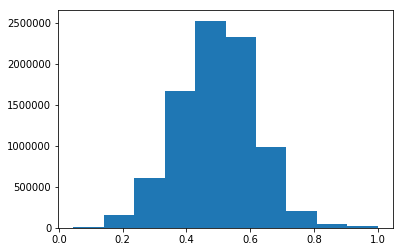

In [110]:
plt.hist(ref_scores_ground)
print(numpy.median(ref_scores_ground))

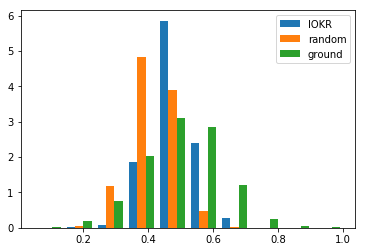

In [124]:
plt.hist([kernel_res[None][0], kernel_res[None][1], ref_scores_ground], label=["IOKR", "random", "ground"], density=True)
plt.legend()
plt.savefig('iokr_perf.pdf')

In [7]:
def test_IOKR_projection(iokrdata):
    """
    Test the projection performance (pre-thresholding)
    """
    fingerprint_projections = []
    for label in set(iokrdata.folds):
        label_indices = iokrdata.get_indices(label, complement=True)
        iokr_opt = iokr.InputOutputKernelRegression(iokrdata)
        iokr_opt.set_training_indices(label_indices, _lambda=0.001)
        iokr_opt.fit()

        indices = numpy.where(iokrdata.folds == label)[0]

        for idx in indices:
            test_res = numpy.array(iokr_opt.project(idx))
            fingerprint_projections.append(test_res)

    return fingerprint_projections

kernel_list = ["ALIGND.txt",
                    "CP2Plus.txt",
                    "CPI.txt",
                    "CPK.txt",
                    "LB.txt",
                    "LI.txt",
                    "NI.txt",
                    "RLB.txt",
                    "ALIGN.txt",
                    "CP2.txt",
                    "CPJB.txt",
                    "CSC.txt",
                    "LC.txt",
                    "LW.txt",
                    "NSF.txt",
                    "RLI.txt",
                    "CEC.txt",
                    "CPC.txt",
                    "CPJ.txt",
                    "FIPP.txt",
                    "LIPP.txt",
                    "NB.txt",
                    "PPKr.txt",
                    "WPC.txt",
                    None]

kernel_list = ['PPKr.txt']

kernel_res = {}
for kernel in kernel_list:
    iokrdata = data.IOKRDataServer(datapath, kernel=kernel)
    fingerprint_projections = test_IOKR_projection(iokrdata)


Loading kernel PPKr.txt


In [8]:
def calculate_auc(pred_values, true_values):
    pred_values = numpy.array(pred_values)
    true_values = numpy.array(true_values)
    if numpy.sum(pred_values) == 0 and numpy.sum(true_values) == 0:
        return 0.0
    cutoff_range = [float(x - 100) / 100 for x in range(200)]
    #cutoff_range = [0.5, 0.6]
    _x = []
    _y = []
    tp_fp_pairs = []
    for cutoff in cutoff_range:
        pred_binary_values = numpy.array([1 if x > cutoff else 0 for x in pred_values])
        tp = numpy.dot(pred_binary_values, true_values)
        fp = numpy.dot(pred_binary_values, 1.0 - true_values)
        tp_rate = tp / numpy.sum(true_values)
        if numpy.sum(1.0 - true_values) == 0:
            fp_rate = 0.0
        else:
            fp_rate = fp / numpy.sum(1.0 - true_values)
        tp_fp_pairs.append((tp_rate, fp_rate))
        
        _x.append(fp_rate)
        _y.append(tp_rate)
        
    tp_fp_pairs.sort(key=lambda x: x[1])
    auc = 0
    last_fp = 0
    for tp, fp in tp_fp_pairs:
        auc += (fp - last_fp) * tp
        last_fp = fp
        
    #plt.scatter(_x, _y)
    #plt.show()
    return auc

sample_fingerprints = [numpy.array(iokrdata.get_sample(i)['fingerprint'].T)[0] for i in range(len(iokrdata.folds))]



KeyboardInterrupt: 

In [31]:
def testIOKR(iokrdata):
    fingerprint_projections = []
    for label in set(iokrdata.folds):
        label_indices = iokrdata.get_indices(label, complement=True)
        iokr_opt = iokr.InputOutputKernelRegression(iokrdata)
        iokr_opt.set_training_indices(label_indices, _lambda=0.001)
        iokr_opt.fit()

        indices = numpy.where(iokrdata.folds == label)[0]

        for idx in indices:
            test_res = numpy.array(iokr_opt.project(idx))
            fingerprint_projections.append(test_res)

    return fingerprint_projections

kernel_list = ["ALIGND.txt",
                    "CP2Plus.txt",
                    "CPI.txt",
                    "CPK.txt",
                    "LB.txt",
                    "LI.txt",
                    "NI.txt",
                    "RLB.txt",
                    "ALIGN.txt",
                    "CP2.txt",
                    "CPJB.txt",
                    "CSC.txt",
                    "LC.txt",
                    "LW.txt",
                    "NSF.txt",
                    "RLI.txt",
                    "CEC.txt",
                    "CPC.txt",
                    "CPJ.txt",
                    "FIPP.txt",
                    "LIPP.txt",
                    "NB.txt",
                    "PPKr.txt",
                    "WPC.txt",
                    None]

# kernel_list = ['PPKr.txt']

print('project')

kernel_res = {}
for kernel in kernel_list:
    print('process %s' % kernel)
    iokrdata = IOKRDataServer(datapath, kernel=kernel)
    fingerprint_projections = testIOKR(iokrdata)
    kernel_res[kernel] = fingerprint_projections
    
sample_fingerprints = [numpy.array(iokrdata.get_sample(i)['fingerprint'].T)[0] for i in range(len(iokrdata.folds))]



project
process ALIGND.txt
Loading kernel ALIGND.txt
process CP2Plus.txt
Loading kernel CP2Plus.txt
process CPI.txt
Loading kernel CPI.txt
process CPK.txt
Loading kernel CPK.txt
process LB.txt
Loading kernel LB.txt
process LI.txt
Loading kernel LI.txt
process NI.txt
Loading kernel NI.txt
process RLB.txt
Loading kernel RLB.txt
process ALIGN.txt
Loading kernel ALIGN.txt
process CP2.txt
Loading kernel CP2.txt
process CPJB.txt
Loading kernel CPJB.txt
process CSC.txt
Loading kernel CSC.txt
process LC.txt
Loading kernel LC.txt
process LW.txt
Loading kernel LW.txt
process NSF.txt
Loading kernel NSF.txt
process RLI.txt
Loading kernel RLI.txt
process CEC.txt
Loading kernel CEC.txt
process CPC.txt
Loading kernel CPC.txt
process CPJ.txt
Loading kernel CPJ.txt
process FIPP.txt
Loading kernel FIPP.txt
process LIPP.txt
Loading kernel LIPP.txt
process NB.txt
Loading kernel NB.txt
process PPKr.txt
Loading kernel PPKr.txt
process WPC.txt
Loading kernel WPC.txt
process None
No kernel specified. Using av

In [64]:
print('auc')

auc_kernel_values = {}
for k in kernel_list:
    print(k)
    for i in range(len(sample_fingerprints[0])):
        a = [x[i] for x in sample_fingerprints]
        b = [x[i] for x in kernel_res[k]]
        if k in auc_kernel_values:
            auc_kernel_values[k].append(calculate_auc(b, a))
        else:
            auc_kernel_values[k] = [calculate_auc(b, a)]

auc
LI.txt
PPKr.txt


False


Text(0, 0.5, 'PPKr AUC')

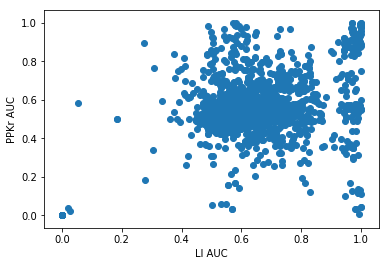

In [74]:
import matplotlib.pyplot as plt
imp.reload(plt)
plt.scatter(auc_kernel_values['LI.txt'], auc_kernel_values['PPKr.txt'])
plt.xlabel('LI AUC')
plt.ylabel('PPKr AUC')

In [ ]:
auc_values = auc_kernel_values['PPKr.txt']
plt.hist(auc_values)
plt.savefig('auc_hist.pdf')

In [216]:

kernel = None

collected_rankings = []
iokrdata = data.IOKRDataServer(datapath, kernel=kernel)
for label in set(iokrdata.folds):
    label_indices = iokrdata.get_indices(label, complement=True)

    iokr_opt = iokr.InputOutputKernelRegression(iokrdata)
    iokr_opt.set_training_indices(label_indices, _lambda=0.001)
    iokr_opt.fit()

    test_indices = iokrdata.get_indices(label)
    for i in test_indices:
        formula = iokrdata.get_sample(i)['formula']
        sample_inchi = iokrdata.get_sample(i)['inchi']
        candidate_inchi = [x[0] for x in iokrdata.get_candidates(formula)]
        candidate_fingerprints = [numpy.array(x[1]) for x in iokrdata.get_candidates(formula)]
        correct_index = candidate_inchi.index(sample_inchi)
        total_count = len(candidate_fingerprints)
        
        print('idx {} - candSize {} - true {}'.format(i, total_count, correct_index))
        ranking = iokr_opt.rank_candidates(i, candidate_fingerprints)
        correct_ranking = ranking.index(correct_index)
        
        print("Ranked {} / {}".format(correct_ranking, total_count))
        collected_rankings.append((correct_ranking, total_count))


No kernel specified. Using average.
idx 5 - candSize 7 - true 0
Ranked 2 / 7
idx 24 - candSize 921 - true 24


KeyboardInterrupt: 

The Probability Product Kernel.

Input for PPK is two spectra as nx2 numpy arrays ((position, intensity)-pairs).

Input for PKKr is the same plus two precursor mass floats.

Question: If the PPKr is supposed to be normalised, do we normalise the component kernels, and then renormalise the final sum, or do we compute them unnormalised and only do the normalisation as a last step?

In [11]:
import itertools

def sigma(x):
    sigma_mass = numpy.std(x[:, 0])
    sigma_int = numpy.std(x[:, 1])
    sigma_mass = 0.5
    sigma_int = 0.5
    sigma_mat = numpy.array([[sigma_mass, 0], [0, sigma_int]])
    return sigma_mat, numpy.linalg.inv(sigma_mat)

def PPK(spec1, spec2, normalised=True):
    if normalised and numpy.all(spec1 == spec2):
        return 1.0
    
    k1 = len(spec1)
    k2 = len(spec2)
    sigma1, sigma1_inv = sigma(spec1)
    sigma2, sigma2_inv = sigma(spec2)
    
    cum = 0
    for p_1, p_2 in itertools.product(spec1, spec2):
        p_dagger = numpy.dot(sigma1_inv, p_2) + numpy.dot(sigma2_inv, p_2)
        sigma_dagger = sigma1_inv + sigma2_inv
        sigma_dagger_inv = numpy.linalg.inv(sigma_dagger)
        factor = 1.0 / (2 * numpy.pi * numpy.sqrt(numpy.linalg.det(sigma1) * numpy.linalg.det(sigma2) * numpy.linalg.det(sigma_dagger)))

        exponent = numpy.dot(numpy.dot(p_1, sigma1_inv), p_1) \
                    + numpy.dot(numpy.dot(p_2, sigma2_inv), p_2) \
                    + numpy.dot(numpy.dot(p_dagger, sigma_dagger_inv), p_dagger)
        cum += factor + numpy.exp(-0.5 * exponent)
    
    unnormalised = cum / (k1 * k2)
    
    if normalised:
        spec1_auto = PPK(spec1, spec1, normalised=False)
        spec2_auto = PPK(spec2, spec2, normalised=False)
        
        return unnormalised / (numpy.sqrt(spec1_auto * spec2_auto))
    else:
        return unnormalised

    
def PPKr(spec1, spec2, prec1, prec2):
    k_peaks = PPK(spec1, spec2)
    
    spec1_loss = ([prec1, 0] - spec1) * [1, -1]
    spec2_loss = ([prec2, 0] - spec2) * [1, -1]
    k_nloss = PPK(spec1_loss, spec2_loss)
    
    spec1_diff = numpy.array([y - x for x, y in itertools.combinations(spec1, 2)])
    spec2_diff = numpy.array([y - x for x, y in itertools.combinations(spec2, 2)])
    k_diff = PPK(spec1_diff, spec2_diff)

    return k_peaks + k_nloss + k_diff


p1 = numpy.array([[2.0, 1.0],
                  [2.5, 0.5],
                  [3.0, 1.0]])
p2 = numpy.array([[0.0, 1.0],
                  [0.5, 0.5],
                  [1.0, 1.0]])

print(PPK(p1, p2))
print(PPKr(p1, p2, 3.0, 1.0))



0.9092767390377636
2.9092767390377636


In [12]:
def _gaussprodmixture(i_peaks, j_peaks, sm, si):
        X1 = i_peaks; X2 = j_peaks;
        N1 = numpy.size(X1,0); N2 = numpy.size(X2,0)
        if N1 == 0 or N2 == 0:
            raise Exception("[ERROR]:No peaks when computing the kernel.(try not clean the peaks)")
        constant = 1.0/(N1*N2)*0.25/(numpy.pi*numpy.sqrt(sm*si))
        print(constant)
        mass_term = 1.0/sm * numpy.power(numpy.kron(X1[:,0].flatten(),numpy.ones(N2)) - numpy.kron(numpy.ones(N1),X2[:,0].flatten()),2)
        inte_term = 1.0/si * numpy.power(numpy.kron(X1[:,1].flatten(),numpy.ones(N2)) - numpy.kron(numpy.ones(N1),X2[:,1].flatten()),2)
        return constant*sum(numpy.exp(-0.25*(mass_term + inte_term)))
        #return constant*sum(numpy.exp(-0.25*(mass_term)))

In [10]:
_gaussprodmixture(p1, p2, 0.5, 0.5)

0.017683882565766147


0.029606418356545663